In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

1. Load The Data

In [2]:
df1 = pd.read_csv("bengaluru_house_prices.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df1.shape

(13320, 9)

In [4]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [5]:
df1.index

RangeIndex(start=0, stop=13320, step=1)

In [6]:
df1['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

2. Drop features that are not required to build our model

In [7]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


# Data Cleaning: Handle NA values

In [8]:
df2.isna().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [9]:
df3 = df2.dropna()
df3.isna().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

# Feature Engineering

In [10]:
df3.loc[:, 'bhk'] = df3['size'].apply(lambda x : int(x.split(' ')[0]))
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [11]:
df3.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

Explore total_sqft feature

In [12]:
type(df3['total_sqft'][0])

str

In [13]:
# if we try to convert '2001' str to float it will be convert but '2001 - 2005' this will not.
# in total_sqrt there is some value like 2001- 2004 so we need to handle this type of value

In [14]:
def is_float(x): 
    try:
        float(x)
    except:
        return False
        
    return True

In [15]:
df3[df3['total_sqft'].apply(is_float)].head(10) # this will give me true value

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2
5,Whitefield,2 BHK,1170,2.0,38.00,2
6,Old Airport Road,4 BHK,2732,4.0,204.00,4
7,Rajaji Nagar,4 BHK,3300,4.0,600.00,4
8,Marathahalli,3 BHK,1310,3.0,63.25,3
9,Gandhi Bazar,6 Bedroom,1020,6.0,370.00,6


In [16]:
df3[~df3['total_sqft'].apply(is_float)].head(10) # this will give df. of range value
# ~ means neglate value that return by the fuction is_float so that only false value dataset will present 

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. 
There are other cases such as 34.46Sq. I am going to just drop such corner cases to keep things simple

In [17]:
def convert_rage(x):
    token = x.split('-')
    if len(token) == 2:
        return (float(token[0]) + float(token[1]) / 2)
    try:
       return float(x)
    except:
        return None

In [18]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_rage)
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [19]:
df4.shape

(13246, 6)

In [20]:
df4 = df4[df4.total_sqft.notnull()]
# df4.iloc[410]  this will remove from df4

In [21]:
# befor this the shape of df4 is 13246 
df4.shape

(13200, 6)

Add new feature called price per square feet

In [22]:
df5 = df4.copy()
df5['price_per_sqft'] = df5.price*100000 / df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [23]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.320000e+04
mean     7.903582e+03
std      1.067277e+05
min      2.678298e+02
25%      4.237918e+03
50%      5.417545e+03
75%      7.307886e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [24]:
df5.location.unique()

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], dtype=object)

In [25]:
len(df5.location.unique())

1298

In [26]:
df5.location  = df5.location.apply(lambda x : x.strip())
location_stats = df5.location.value_counts()
location_stats

location
Whitefield                               533
Sarjapur  Road                           392
Electronic City                          304
Kanakpura Road                           264
Thanisandra                              235
                                        ... 
Kanakapura main  Road                      1
Masjid e Alkareem                          1
Sindhi Colony                              1
Kanakapur main road                        1
Bidere Agarahara, Behind Safal market      1
Name: count, Length: 1287, dtype: int64

In [27]:
location_stats = df5.groupby('location').location.agg('count').sort_values(ascending = False)
# above code is same as location_stats = df5.location.value_counts()
type(location_stats)

pandas.core.series.Series

In [28]:
location_less_then_10 = location_stats[location_stats <= 10]
location_less_then_10

location
Thyagaraja Nagar                                  10
Dodsworth Layout                                  10
Gunjur Palya                                      10
BTM 1st Stage                                     10
Naganathapura                                     10
                                                  ..
4th Block HBR Layout                               1
5th block Koramangala                              1
6th Block Jayanagar                                1
6th Block Rajaji Nagar                             1
6th block banashankari 3rd stage, 100 feet ORR     1
Name: location, Length: 1047, dtype: int64

In [29]:
len(location_less_then_10)

1047

In [30]:
df5.location  = df5.location.apply(lambda x :"other" if x in location_less_then_10 else x)
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [31]:
len(df5.location.unique())

241

In [32]:
df5.location.value_counts()

location
other                        2872
Whitefield                    533
Sarjapur  Road                392
Electronic City               304
Kanakpura Road                264
                             ... 
2nd Phase Judicial Layout      11
Marsur                         11
Bommenahalli                   11
Doddaballapur                  11
HAL 2nd Stage                  11
Name: count, Length: 241, dtype: int64

# Outlier Removal Using Business Logic

As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft.) If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [33]:
df5.shape

(13200, 7)

In [34]:
type((df5.bhk)[0])

numpy.int64

In [35]:
df5[df5.total_sqft / df5.bhk < 300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [36]:
df6 = df5[~(df5.total_sqft / df5.bhk < 300)]
df6.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [37]:
df6.shape

(12456, 7)

# Outlier Removal Using Standard Deviation and Mean

In [38]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6290.299983
std        4175.619211
min         267.829813
25%        4186.725844
50%        5281.690141
75%        6904.652015
max      176470.588235
Name: price_per_sqft, dtype: float64

Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [39]:
def remove_outlier_pps(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        # print(subdf.head())
        # print(key)
        m = np.mean(subdf.price_per_sqft)
        st =  np.std(subdf.price_per_sqft)
        reduce_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out, reduce_df], ignore_index=True)
    return df_out

In [40]:
df7 = remove_outlier_pps(df6)
df7.shape

(10232, 7)

Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

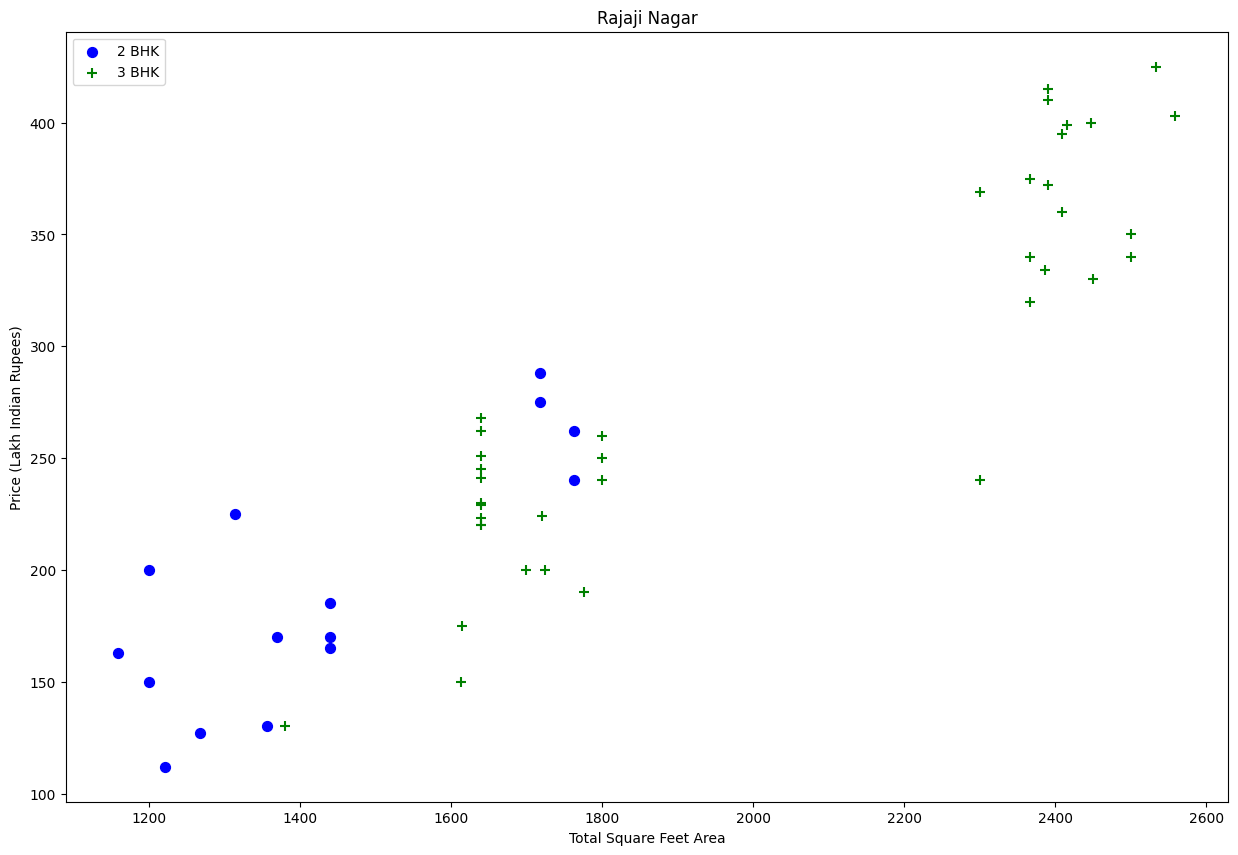

In [41]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    plt.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

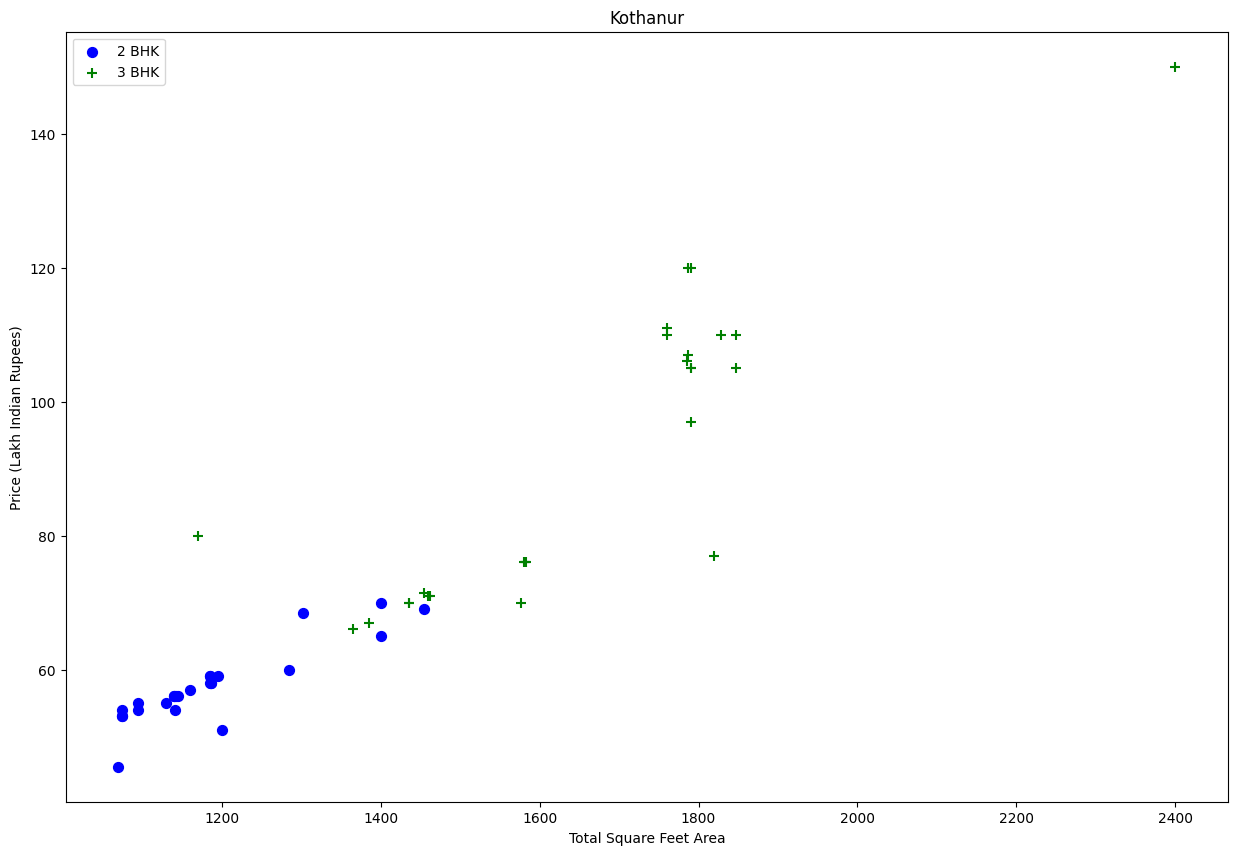

In [42]:
plot_scatter_chart(df7,"Kothanur")

We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.

{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [43]:
def remove_outlier_bhk(df):
    exclude_indices = np.array([])
    for location , location_df in df.groupby('location'):        
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean' : np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
    
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count'] > 5:
                 exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)

        # print(bhk_stats)
    return df.drop(exclude_indices,axis='index')
    
df8 = remove_outlier_bhk(df7)
df8.shape

(7313, 7)

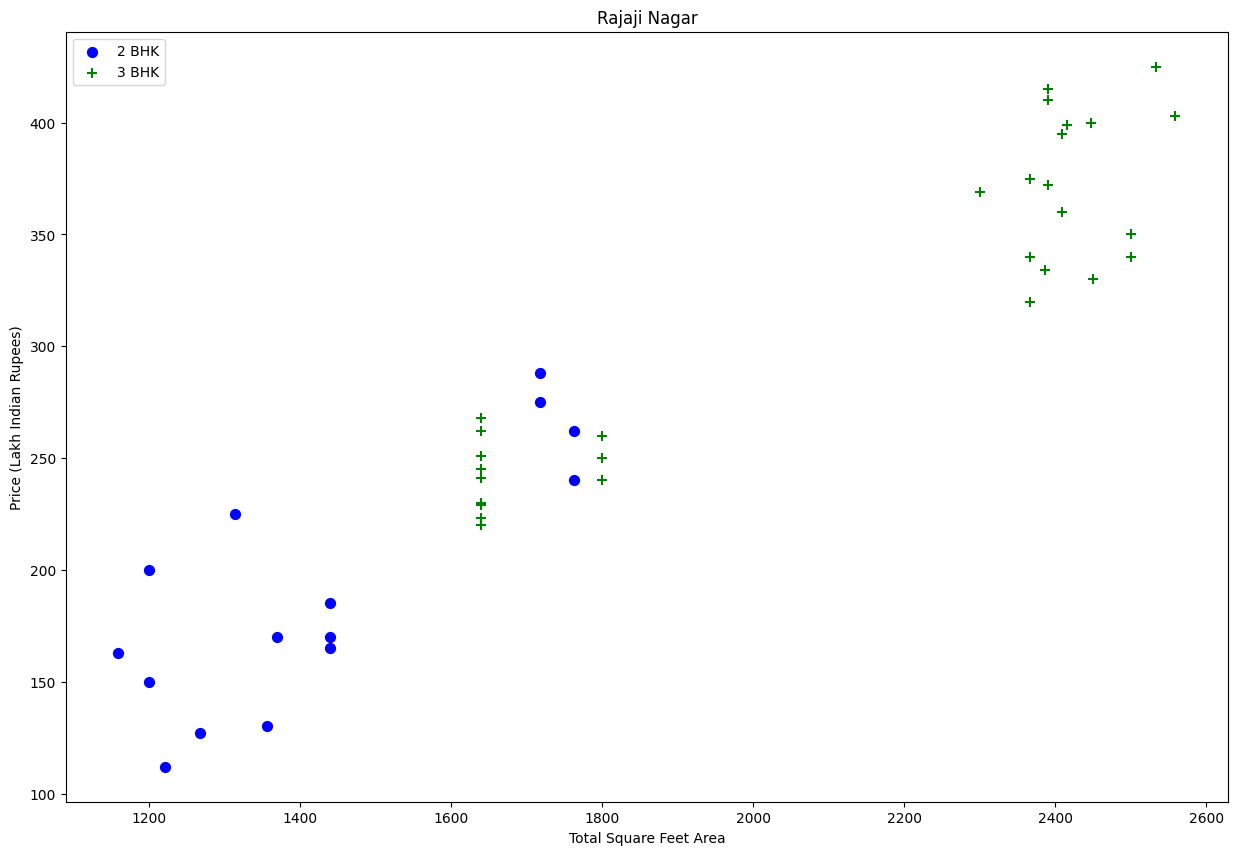

In [44]:
plot_scatter_chart(df8,"Rajaji Nagar")

Text(0, 0.5, 'Count')

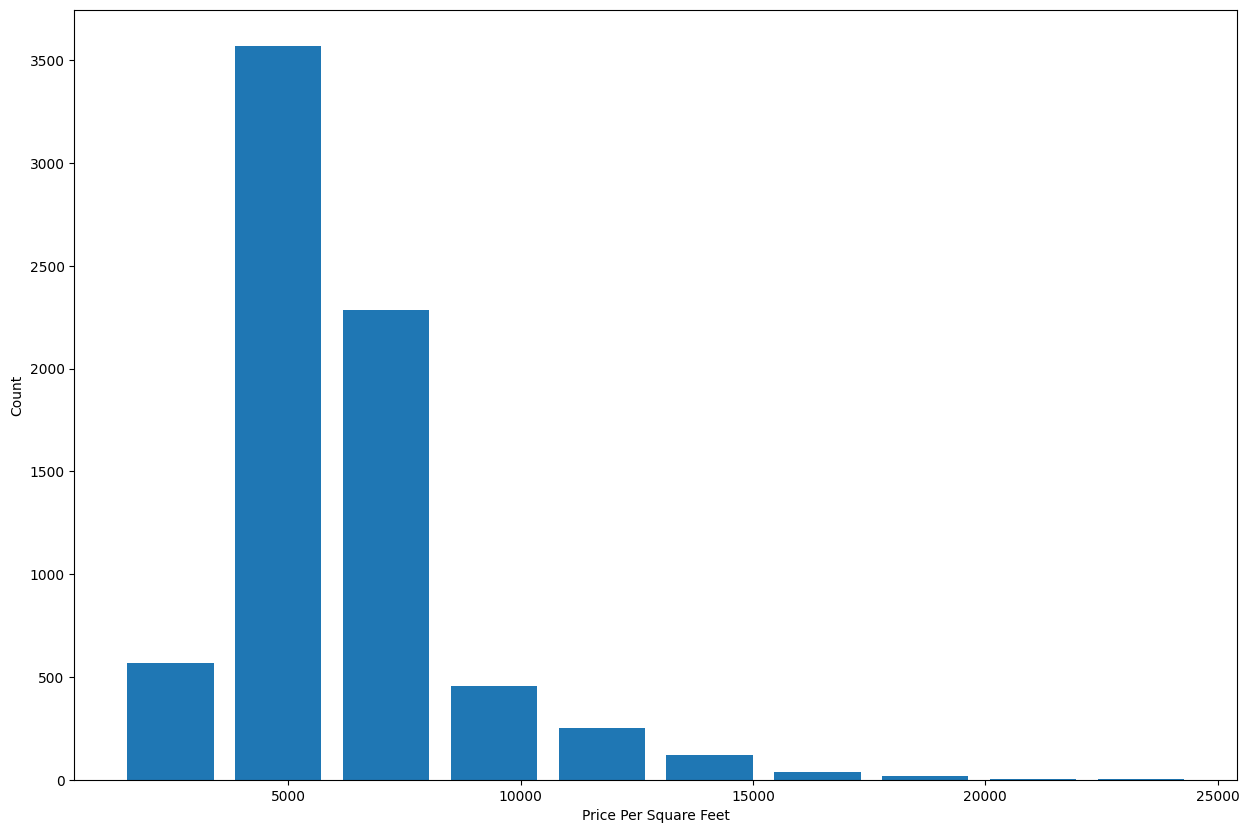

In [45]:
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

# Outlier Removal Using Bathrooms Feature

In [46]:
df8.bath	.value_counts()

bath
2.0     4214
3.0     1761
1.0      551
4.0      498
5.0      172
6.0       77
7.0       15
8.0       13
9.0        7
12.0       3
16.0       1
13.0       1
Name: count, dtype: int64

In [47]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

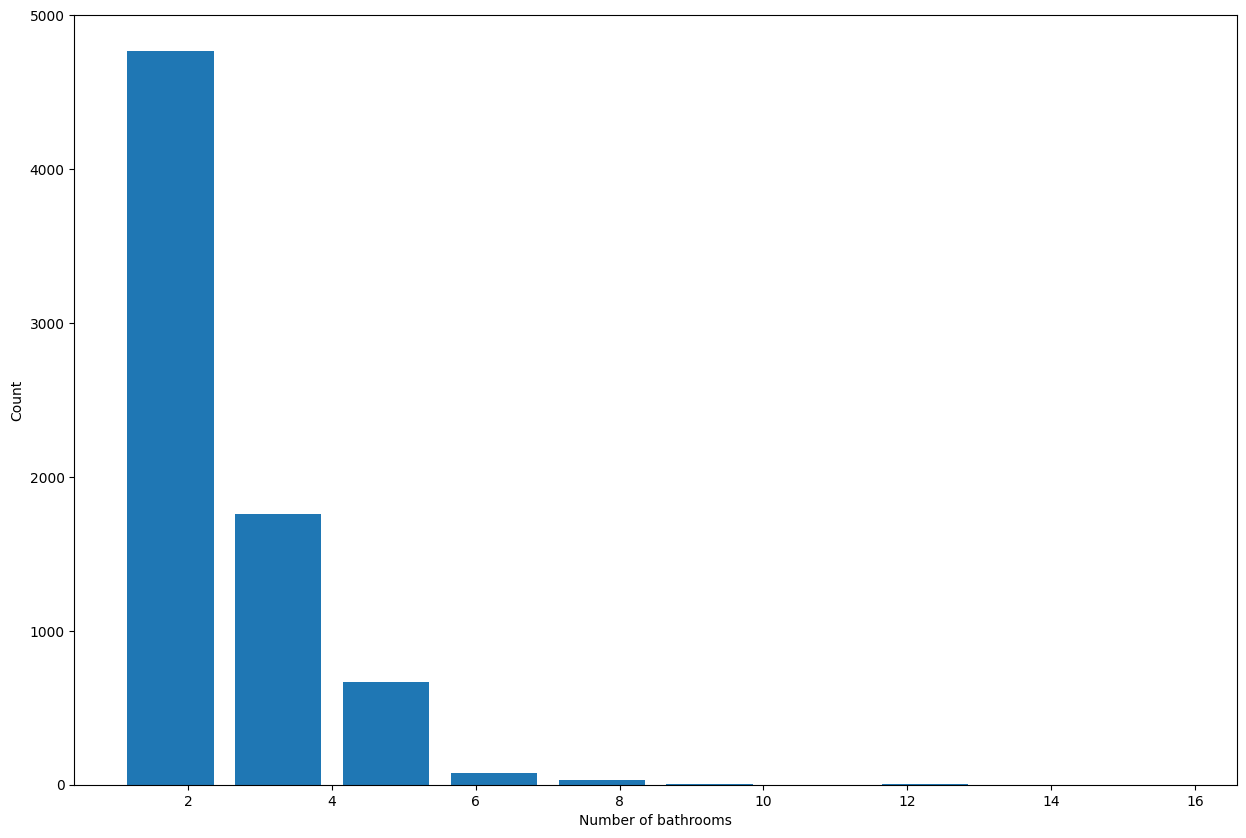

In [48]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [49]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5273,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8473,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8562,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9296,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9627,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


It is unusual to have 2 more bathrooms than number of bedrooms in a home

In [50]:
df8[df8.bath  < df8.bhk +2 ]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668
...,...,...,...,...,...,...,...
10223,other,2 BHK,1200.0,2.0,70.0,2,5833.333333
10224,other,1 BHK,1800.0,1.0,200.0,1,11111.111111
10227,other,2 BHK,1353.0,2.0,110.0,2,8130.081301
10228,other,1 Bedroom,812.0,1.0,26.0,1,3201.970443


In [51]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7239, 7)

In [52]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


In [53]:
dummies = pd.get_dummies(df10.location, dtype = int)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
df11 = pd.concat([df10, dummies.drop('other', axis = 1)], axis = 1 )
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
df12 = df11.drop('location',axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# build Model

In [56]:
df12.shape

(7239, 244)

In [57]:
X = df12.drop(['price'],axis='columns')
y = df12.price

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [59]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8364534927498756

In [60]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.8780757 , 0.87070119, 0.85422219, 0.82886803, 0.78380678])

# Find best model using GridSearchCV

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.843349,{'fit_intercept': False}
1,lasso,0.710795,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.717361,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


# Test the model for few properties

In [62]:
def predict_price(location,sqft,bath,bhk):
    loc_index = np.where(X.columns==location)
    if(loc_index[0].size == 0):
        loc_index = 0
    else:
        loc_index = loc_index[0][0]

    # creat an array that already have 0 in it
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index > 0:
        x[loc_index] = 1
    return lr_clf.predict([x])[0]

In [63]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

np.float64(83.84699754203055)

In [64]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

np.float64(85.72941314141923)

In [65]:
predict_price('Indira Nagar',1000, 2, 2)

np.float64(173.3414760673549)

In [66]:
predict_price('Indira Nagar',1000, 3, 3)

np.float64(175.22389166674355)

# Export the tested model to a pickle file

In [67]:
import pickle

In [68]:
with open('banglore_home_prices_model.pickle', 'wb') as f:
    pickle.dump(lr_clf,f)

# Export location and column information to a file that will be useful later on in our prediction application

In [69]:
import json
column = {
    'data-column' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(column))